In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
# Reading data files

def get_data():
    directory_pwd = '/Users/charbel/Desktop/GitHub/COVID-Hackathon/JohnHopkinsDataSet/'
    directory = os.fsencode(directory_pwd)
    data = []
    labels = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
            full_path = directory_pwd + filename
            df = pd.read_csv(full_path)
            df = df[df.Province_State != "Recovered"]
            df = df.drop(["Lat", "Long_", "Last_Update", "Province_State", "Country_Region", "UID", "ISO3", "FIPS", "Deaths", "Active"], 1)
            df = df.fillna(df.median())
            labels.append(df['Confirmed'].to_numpy())
            df = df.drop(['Confirmed'], 1)
            data.append(df.to_numpy())
    return data, labels


In [3]:
data, labels = get_data()

In [4]:
data = np.stack(data)
labels = np.stack(labels).astype('float64')
# Normalizing data
data_mean, data_std = np.mean(data), np.std(data)
data -= data_mean
data /= data_std
print("data:", data.shape)
labels -= data_mean
labels /= data_std
print("labels:", labels.shape)

data: (104, 58, 7)
labels: (104, 58)


In [5]:
class RNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size=58*7,
                          hidden_size=hidden_size,
                          batch_first=True)
        self.activation1 = nn.ReLU()
        self.proj1 = nn.Linear(in_features=hidden_size,
                              out_features=hidden_size//2)
        self.activation2 = nn.ReLU()
        self.proj2 = nn.Linear(in_features=hidden_size//2,
                              out_features=hidden_size//4)
        self.activation3 = nn.ReLU()
        self.proj3 = nn.Linear(in_features=hidden_size//4,
                              out_features=58)
    def forward(self, inp):
        X = inp.reshape([-1,58*7]).unsqueeze(dim=0)
        out, last_hidden = self.rnn(X)
        proj1 = self.proj1(self.activation1(out))
        proj2 = self.proj2(self.activation2(proj1))
        proj3 = self.proj3(self.activation3(proj2))
        return proj3.squeeze()

In [6]:
rnn = RNN(250)
y = rnn(torch.Tensor(data))
y.shape

torch.Size([104, 58])

In [7]:
train_data, valid_data = data[:83, :], data[83:, :]
print("train_data: ", train_data.shape)
print("valid_data: ", valid_data.shape)
train_labels, valid_labels = labels[:83, :], labels[83:, :]
print("train_labels: ", train_labels.shape)
print("valid_labels ", valid_labels.shape)

train_data:  (83, 58, 7)
valid_data:  (21, 58, 7)
train_labels:  (83, 58)
valid_labels  (21, 58)


In [8]:
def get_batches_and_labels(data, labels, batch_size=10):
    batches = []
    b_labels = []
    for i in range(0, data.shape[0], batch_size):
        batches.append(torch.Tensor(data[i:i+batch_size, :, :]))
        b_labels.append(torch.Tensor(labels[i:i+batch_size, :]))
    return batches, b_labels

b, l = get_batches_and_labels(train_data, train_labels)
for i in range(len(b)):
    print(b[i].shape, "--------", l[i].shape)

torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([10, 58, 7]) -------- torch.Size([10, 58])
torch.Size([3, 58, 7]) -------- torch.Size([3, 58])


In [9]:
def get_accuracy(model, data, labels):
    correct = 0
    out = model(torch.Tensor(data))
    i = abs(float(sum(out[0])) - float(sum(labels[0])))
    for i in range(out.shape[0]):
        difference = abs(float(sum(out[i])) - float(sum(labels[i])))
        if difference <= 0.05:
            correct += 1
    return correct/out.shape[0]
get_accuracy(rnn, train_data, train_labels)

0.012048192771084338

In [10]:
#def get_accuracy(model, data, labels):
#    correct = 0
#    out = model(torch.Tensor(data))
#    denormalize_out = out*data_std + data_mean
#    denormalize_labels = labels*data_std + data_mean
#    for i in range(out.shape[0]):
#        difference = abs(float(sum(denormalize_out[i])) - float(sum(denormalize_labels[i])))
#        if difference <= 10000:
#            correct += 1
#    return correct/out.shape[0]
#get_accuracy(rnn, valid_data, valid_labels)

In [11]:
def train_model(model, train_data, valid_data, train_labels, valid_labels, batch_size=10, weight_decay=0.0,
          learning_rate=0.001, num_epochs=40, checkpoint_path=None):
    
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    iters, losses, train_acc, val_acc = [], [], [], []   
    n = 0
    for epoch in range(num_epochs):
        
        batches, labels = get_batches_and_labels(train_data, train_labels, batch_size=batch_size)
        
        for i in range(len(batches)):
            model.train()
            out = model(batches[i])
            target = labels[i]
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            n += 1
            
        # save the current training information
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data, train_labels)
        vacc = get_accuracy(model, valid_data, valid_labels)
        print("Epoch %d; Loss %f; Train Acc %.3f; Val Acc %.3f;" % (epoch+1, loss, tacc, vacc))
            
        iters.append(n)
        losses.append(loss)
        train_acc.append(tacc)
        val_acc.append(vacc)
        
        if (checkpoint_path is not None) and n > 0:
            torch.save(rnn.state_dict(), checkpoint_path + "epoch-" + str(epoch) + '.pt')
        
    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
        
    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.000001; Train Acc 0.687; Val Acc 0.619;
Epoch 2; Loss 0.000001; Train Acc 0.602; Val Acc 0.333;
Epoch 3; Loss 0.000000; Train Acc 0.506; Val Acc 0.714;
Epoch 4; Loss 0.000000; Train Acc 0.747; Val Acc 0.619;
Epoch 5; Loss 0.000000; Train Acc 0.759; Val Acc 0.714;
Epoch 6; Loss 0.000000; Train Acc 0.627; Val Acc 0.571;
Epoch 7; Loss 0.000000; Train Acc 0.819; Val Acc 0.714;
Epoch 8; Loss 0.000000; Train Acc 0.819; Val Acc 0.762;
Epoch 9; Loss 0.000000; Train Acc 0.711; Val Acc 0.667;
Epoch 10; Loss 0.000000; Train Acc 0.783; Val Acc 0.714;
Epoch 11; Loss 0.000000; Train Acc 0.819; Val Acc 0.762;
Epoch 12; Loss 0.000000; Train Acc 0.795; Val Acc 0.762;
Epoch 13; Loss 0.000000; Train Acc 0.783; Val Acc 0.762;
Epoch 14; Loss 0.000000; Train Acc 0.783; Val Acc 0.714;
Epoch 15; Loss 0.000000; Train Acc 0.783; Val Acc 0.667;
Epoch 16; Loss 0.000000; Train Acc 0.807; Val Acc 0.714;
Epoch 17; Loss 0.000000; Train Acc 0.807; Val Acc 0.714;
Epoch 18; Loss 0.000000; Train Acc 0.795

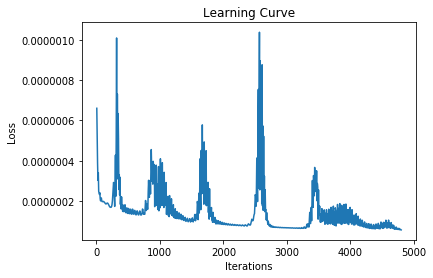

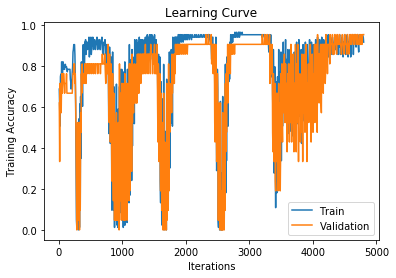

In [15]:
train_model(rnn, train_data, valid_data, train_labels, valid_labels, batch_size=14, weight_decay=0.0,
          learning_rate=0.0001, num_epochs=800, checkpoint_path='/Users/charbel/Desktop/GitHub/COVID-Hackathon/rnn_weights/')

In [16]:
print(valid_data[0].shape)
print(valid_labels[0].shape)

(58, 7)
(58,)


In [50]:
# Number of confirmed COVID cases predicted by the RNN on the 12th day in the validation set
float(sum(rnn(torch.Tensor(valid_data[12])) * data_std + data_mean))

2113258.0

In [51]:
# The actual number of confirmed COVID cases
sum(valid_labels[12]* data_std + data_mean)

2114026.0

In [52]:
# The difference between the prediction and reality
abs(float(sum(rnn(torch.Tensor(valid_data[12])) * data_std + data_mean)) - sum(valid_labels[12]* data_std + data_mean))

768.0